# Sample Code to Run SC-Net

In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import numpy as np
import random
import torch

seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

## Load Data

In [15]:
# Prerequisite: pip install SurvSet
from SurvSet.data import SurvLoader

dataset_name = "prostateSurvival"
loader = SurvLoader()
df, _ = loader.load_dataset(ds_name=dataset_name).values()
print(df.head())

   pid  event  time fac_grade fac_stage fac_ageGroup
0    0      0    18      mode       T1c          80+
1    1      0    23      mode      T1ab        75-79
2    2      0    37      poor       T1c        75-79
3    3      0    27      mode        T2        70-74
4    4      0    42      mode       T1c        70-74


## Encode Features

In [16]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# rescale numerical features into [0, 1]
cols_cont = [col for col in df.columns if col.startswith("num_")]
if len(cols_cont) > 0:
    df[cols_cont] = df[cols_cont].fillna(df[cols_cont].median())
    mm = MinMaxScaler()
    df[cols_cont] = mm.fit_transform(df[cols_cont])

# encode categorical columns
cols_cat = []
for col in df.columns:
    if col.startswith("fac_"):
        cols_cat.append(col)
df = pd.get_dummies(df, columns=cols_cat, drop_first=True, dtype="float32")
print(df.head())

   pid  event  time  fac_grade_poor  fac_stage_T1c  fac_stage_T2  \
0    0      0    18             0.0            1.0           0.0   
1    1      0    23             0.0            0.0           0.0   
2    2      0    37             1.0            1.0           0.0   
3    3      0    27             0.0            0.0           1.0   
4    4      0    42             0.0            1.0           0.0   

   fac_ageGroup_70-74  fac_ageGroup_75-79  fac_ageGroup_80+  
0                 0.0                 0.0               1.0  
1                 0.0                 1.0               0.0  
2                 0.0                 1.0               0.0  
3                 1.0                 0.0               0.0  
4                 1.0                 0.0               0.0  


## Split Dataset

In [17]:
from sklearn.model_selection import train_test_split

min_y = 0.0
max_y = df["time"].max()

df_train, df_test = train_test_split(df, random_state=42, test_size=0.2) 
print(df_train.shape, df_test.shape)

(11435, 9) (2859, 9)


## Train with Neural Network (SC-Net)

In [18]:
import cenreg.pytorch.copula_torch
from cenreg.pytorch.datamodule import SurvDataModule
from cenreg.pytorch.loss_cont import CopulaNegativeLogLikelihood
from cenreg.pytorch.mlp import SMM_MultiHead

# drop the columns that are not needed
x_train = df_train.drop(columns=["pid", "time", "event"]).values
x_test = df_test.drop(columns=["pid", "time", "event"]).values

# preparation for PyTorch training
sdm = SurvDataModule(128)
train_dataloader = sdm.train_dataloader(x_train, df_train["time"].values, df_train["event"].values)
model = SMM_MultiHead(x_train.shape[1], 1, 2, 16)

# create a copula object
copula_torch = cenreg.pytorch.copula_torch.create("independence")
# prepare the loss function
loss_fn = CopulaNegativeLogLikelihood(copula_torch)

In [19]:
import cenreg.pytorch.utils

optimizer_mlp = torch.optim.Adam(model.parameters(), lr=1.0)
for epoch in range(10):
    loss_sum = 0.0
    for i, data in enumerate(train_dataloader):
        x, t, e = data

        optimizer_mlp.zero_grad()
        t_grad = t.view(-1, 1).clone().detach().requires_grad_(True)
        t_grad = cenreg.pytorch.utils.normalize_y(t_grad, min_y, max_y)
        F_pred = model(x, t_grad)
        loss = loss_fn.loss(F_pred, t_grad, e).mean()
        loss_sum += loss.item()
        loss.backward()
        optimizer_mlp.step()
    print(f"Epoch {epoch+1}, Train Loss: {loss_sum / len(train_dataloader)}")


Epoch 1, Train Loss: 0.31274175867438314
Epoch 2, Train Loss: 0.1699182650488284
Epoch 3, Train Loss: 0.14413190956951843
Epoch 4, Train Loss: 0.17235662221080728
Epoch 5, Train Loss: 0.1399189831275079
Epoch 6, Train Loss: 0.15406331359926198
Epoch 7, Train Loss: 0.15370798817732267
Epoch 8, Train Loss: 0.1371321897332867
Epoch 9, Train Loss: 0.13695469473799068
Epoch 10, Train Loss: 0.14057688855876524


## Predict

In [20]:
import cenreg.utils
from cenreg.distribution.linear import LinearCDF

num_bins = 32
bins = torch.tensor(cenreg.utils.create_bins(max_y, 0.0, num_bins), dtype=torch.float32)

test_dataloader = sdm.test_dataloader(x_test, df_test["time"].values, df_test["event"].values)
model.eval()
with torch.no_grad():
    for i, data in enumerate(test_dataloader):
        x, _, _ = data
        list_pred = []
        for t in bins:
            t = cenreg.pytorch.utils.normalize_y(t, min_y, max_y)
            t_expand = t.expand(x.shape[0], 1)
            pred = model(x, t_expand)
            list_pred.append(pred)
        F_pred = torch.stack(list_pred, dim=2)
        F_pred[:,:,0] = 0.0
        F_pred[:,:,-1] = 1.0
        break  # assuming that the first batch contains all the test data
print("F_pred", F_pred[0,:,:], F_pred.shape)

bins_np = bins.detach().cpu().numpy()
F_pred_np = F_pred.detach().cpu().numpy()
list_t_dist = []
for k in range(2):
    list_t_dist.append(LinearCDF(bins_np, F_pred_np[:,k,:], apply_cumsum=False))

F_pred tensor([[0.0000, 0.1252, 0.1932, 0.2826, 0.3730, 0.4326, 0.4713, 0.5055, 0.5388,
         0.5716, 0.6039, 0.6352, 0.6655, 0.6944, 0.7219, 0.7478, 0.7721, 0.7946,
         0.8155, 0.8347, 0.8523, 0.8682, 0.8827, 0.8958, 0.9076, 0.9182, 0.9276,
         0.9361, 0.9436, 0.9503, 0.9562, 0.9614, 1.0000],
        [0.0000, 0.0052, 0.0074, 0.0107, 0.0152, 0.0198, 0.0214, 0.0232, 0.0251,
         0.0271, 0.0293, 0.0317, 0.0343, 0.0370, 0.0400, 0.0432, 0.0466, 0.0504,
         0.0543, 0.0586, 0.0632, 0.0682, 0.0734, 0.0791, 0.0852, 0.0916, 0.0985,
         0.1059, 0.1138, 0.1221, 0.1310, 0.1405, 1.0000]]) torch.Size([2859, 2, 33])


## Convert

In [21]:
import cenreg.model.copula_np
import cenreg.model.F2cjd_np

num_risks = 2
list_Fpred = []
for k, d in enumerate(list_t_dist):
    F_pred = d.cdf(bins_np[1:-1], add_edges=True)
    if F_pred.ndim == 1:
        F_pred = F_pred.reshape(1, -1)
    list_Fpred.append(F_pred)
F_pred = np.stack(list_Fpred, axis=1)

copula_np = cenreg.model.copula_np.IndependenceCopula()
list_K = list(range(num_risks))
w = [0.0] + [1 / i for i in range(1, num_risks + 1)]
jd_pred = np.zeros((F_pred.shape[0], num_risks, bins_np.shape[0] - 1))
for k in list_K:
    for t in range(F_pred.shape[2] - 1):
        temp = F_pred[:, :, t : t + 2]
        ones = np.ones((temp.shape[0], temp.shape[1], 1))
        temp = np.concatenate([temp, ones], axis=2)
        jd_pred[:, k, t] = cenreg.model.F2cjd_np.convert(
            temp, copula_np, w, num_risks, k, list_K
        )

## Evaluate Model

In [22]:
import cenreg.metric.cdf
import cenreg.metric.cjd
import cenreg.metric.quantile
import cenreg.model.copula_np

cjd_pred = jd_pred.reshape(-1, num_bins * 2)
observed_times = df_test['time'].values
events = df_test["event"].astype(bool).values

# Compute Brier score on CJD representation
cjd_brier = cenreg.metric.cjd.brier(observed_times, events, 2, cjd_pred, bins_np)
print("CJD-Brier", cjd_brier.mean())

# Compute Logarithmic score on CDF representation
cjd_logarithmic = cenreg.metric.cjd.negative_loglikelihood(observed_times, events, cjd_pred, bins_np)
print("CJD-Logarithmic", cjd_logarithmic.mean())

# Compute KS calibration error on CDF representation
cjd_ks = cenreg.metric.cjd.kolmogorov_smirnov_calibration_error(observed_times, events, cjd_pred, bins_np)
print("CJD-KS", cjd_ks)

# Compute NLL-SC metric
copula_np = cenreg.model.copula_np.IndependenceCopula()
survival_copula_np = cenreg.model.copula_np.SurvivalCopula(copula_np)
nll_sc = cenreg.metric.cdf.nll_sc(list_t_dist, observed_times, events, survival_copula_np)
print("NLL-SC", nll_sc.mean())

# Compute cen-log metric
nll = cenreg.metric.cdf.negative_loglikelihood(list_t_dist[1], observed_times, events)
print("Cen-log", nll.mean())

# Compute D-calibration
quantiles_cal = np.linspace(0.0, 1.0, 11)
dcal = cenreg.metric.quantile.d_calibration(list_t_dist[1], observed_times, events, quantiles_cal)
print("D-calibration", dcal)

# Compute KM-calibration
kmcal = cenreg.metric.cdf.km_calibration(list_t_dist[1], observed_times, events, bins_np)
print("KM-calibration", kmcal)

CJD-Brier 0.9645153392245996
CJD-Logarithmic 3.5418869960575394
CJD-KS 0.34055711544819794
NLL-SC 4.885996452186602
Cen-log 0.3756013711177897
D-calibration 0.0005720768376036918
KM-calibration 0.07591133723918518


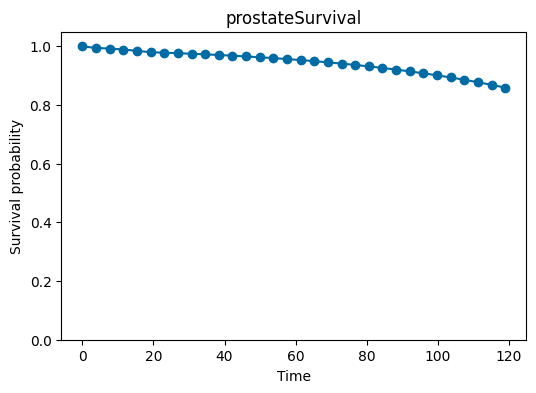

In [23]:
%matplotlib inline

import matplotlib.pyplot as plt

x = list_t_dist[1].boundaries
y = 1.0 - list_t_dist[1].cdf(x)

plt.style.use("tableau-colorblind10")
plt.figure(figsize=(6, 4))
plt.title(dataset_name)
plt.xlabel("Time")
plt.ylabel("Survival probability")
plt.ylim(0.0, 1.05)
plt.plot(x[:-1], y[50,:-1], marker='o')  # Plot the 50th survival function
plt.show()